<a href="https://colab.research.google.com/github/Madhusudhanbandi/EVA-S11/blob/master/EVA_S11_ASSIG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import torchvision
from torchsummary import summary
from myfunctions import *
from models import *
from Grad_Cam import get_last_conv,Grad_Cam
from transforms_dataloading import *
from tqdm import tqdm

from albumentations import  ( 
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, PadIfNeeded ,Rotate,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose , Normalize ,ToFloat, Cutout
)

import cv2

import numpy as np

from albumentations.pytorch import  ToTensor 
 

**Downloading datasets and applying transforms**

In [4]:
trainset,testset =downloading_data_transforms_albumentations_v1(
            #pass dataset
            datasets.CIFAR10,

            # train transforms                                               
            Compose([
            PadIfNeeded(min_height=40,min_width=40,border_mode=4) ,
            Flip(),
            RandomCrop(height=32,width=32),
            Cutout(num_holes=8, max_h_size=8, max_w_size=8),
            Normalize( mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616],),
            ToTensor()
            ]),

            # test transforms
            Compose([
            Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2471, 0.2435, 0.2616],),
            ToTensor()
            ])
            )

Files already downloaded and verified
Files already downloaded and verified
No.of images in train set are 50000
No.of images in test set are 10000


**Loading data to train and test loader**

In [5]:
trainloader,testloader=loading_to_train_test_loader(1,trainset,testset,512)


CUDA Available? True
Train and Test data loaded.......


**Building model network**

In [6]:
Net= own_resnet_model()

Model was build as per given architucture....


**Adding model to device**

In [7]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model,input_size=(3,32,32))
print("Model added to device")

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

**LR Range test**

In [8]:
import torch.optim as optim
train_los=[]
train_acs=[]
test_los=[]
test_acs=[]
lr_data=[]

L2lambda=0
lr=0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,nesterov=True, weight_decay=L2lambda)

EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    
    train_losses,train_acces,lr=training_model_with_linear_incremental_lr(epoch,model, device, trainloader, optimizer,criterion)
    lr_data.append(lr)
    train_acs.append(train_acces)


EPOCH: 0
LR used in this epoch 0.01

Train set: Average loss: 0.7647, Train Accuracy: (24.79%)

EPOCH: 1
LR used in this epoch 0.02

Train set: Average loss: 0.6915, Train Accuracy: (31.38%)

EPOCH: 2
LR used in this epoch 0.03

Train set: Average loss: 0.7141, Train Accuracy: (34.49%)

EPOCH: 3
LR used in this epoch 0.04

Train set: Average loss: 0.7374, Train Accuracy: (35.53%)

EPOCH: 4
LR used in this epoch 0.05

Train set: Average loss: 0.6768, Train Accuracy: (39.08%)

EPOCH: 5
LR used in this epoch 0.06

Train set: Average loss: 0.7631, Train Accuracy: (38.42%)

EPOCH: 6
LR used in this epoch 0.07

Train set: Average loss: 0.6744, Train Accuracy: (43.00%)

EPOCH: 7
LR used in this epoch 0.08

Train set: Average loss: 0.8175, Train Accuracy: (38.43%)

EPOCH: 8
LR used in this epoch 0.09

Train set: Average loss: 0.7973, Train Accuracy: (40.93%)

EPOCH: 9
LR used in this epoch 0.1

Train set: Average loss: 0.6835, Train Accuracy: (44.65%)



Text(0, 0.5, 'Accuracy')

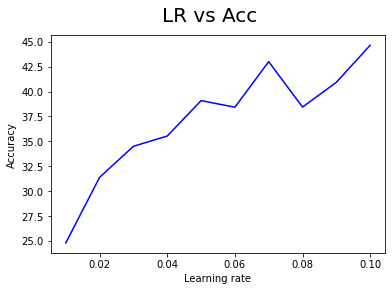

In [9]:

import pandas as pd
lr_datadf=pd.DataFrame(lr_data,columns=['LR'])
acsdf=pd.DataFrame(train_acs,columns=['ACC'])

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(lr_datadf['LR'],acsdf['ACC'],color='blue')
plt.suptitle('LR vs Acc ',fontsize=20)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')


**Traing network with SGD and OneCycleLR schedular**

In [8]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR


train_los=[]
train_acs=[]
test_los=[]
test_acs=[]
lr_data=[]

L2lambda=0
ep=len(trainloader)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,nesterov=True, weight_decay=L2lambda)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, epochs=24,steps_per_epoch=ep,pct_start=0.2)
  

EPOCHS = 24
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_losses,train_acces=training_model_with_scheduler(model, device, trainloader, optimizer,scheduler,criterion)
    train_acs.append(train_acces)
    test_losses, test_acces=testing_model(model, device, testloader)
    test_acs.append(test_acces)

EPOCH: 1
LR used in this epoch is: 0.013764751199348696

Train set: Average loss: 0.5909, Train Accuracy: (31.73%)


Test set: Average Loss: 0.1799, Test Accuracy: 4005/10000 (40.05%)

EPOCH: 2
LR used in this epoch is: 0.03939576846136664

Train set: Average loss: 0.5121, Train Accuracy: (43.58%)


Test set: Average Loss: 0.1145, Test Accuracy: 5259/10000 (52.59%)

EPOCH: 3
LR used in this epoch is: 0.07025744715202284

Train set: Average loss: 0.5560, Train Accuracy: (45.72%)


Test set: Average Loss: 0.1623, Test Accuracy: 4747/10000 (47.47%)

EPOCH: 4
LR used in this epoch is: 0.09354242239108235

Train set: Average loss: 0.4139, Train Accuracy: (54.92%)


Test set: Average Loss: 0.0727, Test Accuracy: 6560/10000 (65.60%)

EPOCH: 5
LR used in this epoch is: 0.09997322948090079

Train set: Average loss: 0.3238, Train Accuracy: (61.80%)


Test set: Average Loss: 0.0840, Test Accuracy: 6171/10000 (61.71%)

EPOCH: 6
LR used in this epoch is: 0.09903926786310545

Train set: Average loss

**Cyclic LR -Triangular plot**

EPOCH: 1
Learning rate is: 0.0325
EPOCH: 2
Learning rate is: 0.05500000000000001
EPOCH: 3
Learning rate is: 0.0775
EPOCH: 4
Learning rate is: 0.1
EPOCH: 5
Learning rate is: 0.0775
EPOCH: 6
Learning rate is: 0.05500000000000001
EPOCH: 7
Learning rate is: 0.0325
EPOCH: 8
Learning rate is: 0.01
EPOCH: 9
Learning rate is: 0.0325
EPOCH: 10
Learning rate is: 0.05500000000000001
EPOCH: 11
Learning rate is: 0.0775
EPOCH: 12
Learning rate is: 0.1
EPOCH: 13
Learning rate is: 0.0775
EPOCH: 14
Learning rate is: 0.05500000000000001
EPOCH: 15
Learning rate is: 0.0325
EPOCH: 16
Learning rate is: 0.01
EPOCH: 17
Learning rate is: 0.0325
EPOCH: 18
Learning rate is: 0.05500000000000001
EPOCH: 19
Learning rate is: 0.0775
EPOCH: 20
Learning rate is: 0.1
EPOCH: 21
Learning rate is: 0.0775
EPOCH: 22
Learning rate is: 0.05500000000000001
EPOCH: 23
Learning rate is: 0.0325
EPOCH: 24
Learning rate is: 0.01


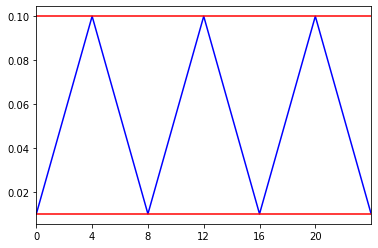

In [9]:
import math 

epos=[0]
lr_min=0.01
lr_max=0.1
lrplt=[0.01]
stepsize=4
iters=len(trainloader)

EPOCHS = 24
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    epos.append(epoch+1)
    cycle=math.floor(1+(iters*(epoch+1))/(2*(stepsize*iters)))
    x= abs(((iters*(epoch+1))/(stepsize*iters))-(2*cycle)+1)
    lrs=lr_min +(lr_max -lr_min)*(1-x)
    print("Learning rate is:",lrs)
    lrplt.append(lrs)

import pandas as pd
epochdf=pd.DataFrame(epos,columns=['Epoch'])
lrpltdf=pd.DataFrame(lrplt,columns=['LR'])

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(epochdf['Epoch'],lrpltdf['LR'],color='blue')
plt.xlim([0,24])
plt.xticks(np.arange(0, 24, step=4))
plt.axhline(y=0.01, color='r', linestyle='-')
plt.axhline(y=0.1, color='r', linestyle='-')
